In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

''' **********************************************************
GET DATA
********************************************************** '''
raw_results = pd.read_csv('data/results.csv')
raw_races = pd.read_csv('data/races.csv')
raw_drivers = pd.read_csv('data/drivers.csv')
raw_circuits = pd.read_csv('data/circuits.csv')
raw_constructor = pd.read_csv('data/constructors.csv')
raw_status = pd.read_csv('data/status.csv')
raw_constructor_standings = pd.read_csv('data/constructor_standings.csv')
raw_qualify = pd.read_csv('data/qualifying.csv')

''' **********************************************************
CLEAN DATA - INITIAL
********************************************************** '''
# remove unwated cols
raw_results = raw_results.drop(columns=['position', 'milliseconds'])
raw_races = raw_races.drop(columns=['url'])
raw_drivers = raw_drivers.drop(columns=['url'])
raw_circuits = raw_circuits.drop(columns=['url'])
raw_constructor = raw_constructor.drop(columns=['url'])
raw_constructor_standings = raw_constructor_standings.drop(columns=['positionText'])
#raw_status = raw_status.drop()
#raw_qualify = raw_qualify.drop()

#rename some cols before merging since it gets confusing what some cols are referring to and merge.suffix is inadequate
# don't rename the Id column
raw_circuits.columns = raw_circuits.columns.map(lambda x: str(x) + '_cir' if str(x)[-2:]!='Id' else str(x))
raw_results.columns = raw_results.columns.map(lambda x: str(x) + '_result' if str(x)[-2:]!='Id' else str(x))
raw_drivers.columns = raw_drivers.columns.map(lambda x: str(x) + '_driver' if str(x)[-2:]!='Id' else str(x))
raw_races.columns = raw_races.columns.map(lambda x: str(x) + '_race' if str(x)[-2:]!='Id' else str(x))
raw_constructor.columns = raw_constructor.columns.map(lambda x: str(x) + '_constr' if str(x)[-2:]!='Id' else str(x))
#raw_status.columns = raw_status.columns.map(lambda x: str(x) + '_stat' if str(x)[-2:]!='Id' else str(x))
raw_qualify.columns = raw_qualify.columns.map(lambda x: str(x) + '_qual' if str(x)[-2:]!='Id' else str(x))


#check nationality and other categorical cols don't have misspelling - check for uniques to do this

''' **********************************************************
MERGE DATA
********************************************************** '''
#LEFT JOIN Results on Drivers
mg_results_driver = pd.merge(raw_results, raw_drivers, on='driverId', how='left', suffixes=('', '_driver'))
print(f'mg_results_driver: {mg_results_driver.shape}')
#LEFT JOIN Races on Circuits
mg_race_circuit = pd.merge(raw_races, raw_circuits, on='circuitId', how='left', suffixes=('_race', '_circuit'))
#Bring the two DFs from above together with LEFT JOIN Results/Drivers on Races/Circuits
mg_res_dr_rac_cir = pd.merge(mg_results_driver, mg_race_circuit, on='raceId', how='left', suffixes=('', '_race'))
#LEFT JOIN Above on Constructors
mg_res_dr_rac_cir_const = pd.merge(mg_res_dr_rac_cir, raw_constructor, on='constructorId', how='left', suffixes=('', '_constr'))
#LEFT JOIN Above on Atatus
df_all = pd.merge(mg_res_dr_rac_cir_const, raw_status, on='statusId', how='left')

#Check sapes to see if they look right and numer of rows matches between raw_results and df_all
# print(f'mg_results_driver: {mg_results_driver.shape}')
# print(f'mg_race_circuit: {mg_race_circuit.shape}')
# print(f'mg_res_dr_rac_cir: {mg_res_dr_rac_cir.shape}')
# print(f'mg_res_dr_rac_cir_const: {mg_res_dr_rac_cir_const.shape}')
# print(f'df_all: {df_all.shape}')

''' **********************************************************
DATA CLEANUP - FINAL
********************************************************** '''
# deal with nulls - 
# or with this data '\N' values that were used to stand for null
replace_val = -1
for col_name in df_all.columns:
    if df_all[col_name].dtype in ['int32', 'int64','float32', 'float64']:
        df_all[col_name].replace(r'\\N',  replace_val, regex=True, inplace=True)
    else:
        df_all[col_name].replace(r'\\N',  str(replace_val), regex=True, inplace=True)
        
# test with row 5 where we know there is a \N entry
# print(f'time_result rows with newline escape: {df_all["time_result"][5:10]}')

# convert cols that should be numbers
df_all.astype({'number_result' : 'int32', 'fastestLapSpeed_result' : 'float32'})

# convert cols that should be dates
d_format = '%Y-%m-%d'
df_all['dob_driver'] = df_all['dob_driver'].map(lambda x : dt.datetime.strptime(x, d_format))
df_all['date_race'] = df_all['date_race'].map(lambda x : dt.datetime.strptime(x, d_format))

#time convertions to datetime.time
#df_all['time_race'] = df_all['time_race'].map(lambda x : dt.datetime.strptime(x, '%H:%M:%S'))

#timings - timedelta objs
'''
df_all['time_result'] = df_all['time_result'].map(lambda x : pd.to_timedelta(x, unit=?))
fastestLapTime_result
'''

#since the driver's nationality is not the same string as their home country, need to create a new col for country_driver
#nationalities = df_all['nationality_driver'].sort_values().unique()
#countries = df_all['country_cir'].sort_values().unique()

driver_countries = {'British': 'UK', 'German': 'Germany', 'Spanish': 'Spain', 'Finnish': 'Finland', 'Japanese': 'Japan', 'French': 'France', 'Polish': 'Poland',
 'Brazilian': 'Brazil', 'Italian': 'Italy', 'Australian': 'Australia', 'Austrian': 'Austria', 'American': 'USA', 'Dutch': 'Netherlands',
 'Colombian': 'Columbia', 'Portuguese': 'Portugal', 'Canadian': 'Canada', 'Indian': 'India', 'Hungarian': 'Hungary', 'Irish': 'Ireland', 'Danish': 'Denmark',
 'Malaysian': 'Malaysia', 'Argentine': 'Argentina', 'Czech': 'Czech Republic', 'Belgian': 'Belgium', 'Swiss': 'Switzerland', 'Monegasque': 'Monaco', 'Swedish': 'Sweden',
 'Venezuelan': 'Venezuela', 'New Zealander': 'New Zealand', 'Chilean': 'Chile', 'Mexican': 'Mexico', 'South African': 'South Africa',
 'Liechtensteiner': 'Liechtenstein', 'Rhodesian': 'Rhodesia', 'American-Italian': 'USA', 'Uruguayan': 'Uruguay',
 'Argentine-Italian': 'Italy', 'Thai': 'Thailand', 'East German': 'Germany', 'Russian': 'Russia', 'Indonesian': 'Indonesia'
}

def map_country_from_nationality(nationality):
    return driver_countries[nationality]

df_all['country_driver'] = df_all['nationality_driver'].apply(map_country_from_nationality)

print(df_all[['surname_driver', 'nationality_driver', 'country_driver']].head())

# save to .csv
df_all.to_csv('data/df_all.csv')

''' **********************************************************
ANALYSIS
********************************************************** '''
#ORDER - mask - grouby - agg - col selection - sort

#***Number of wins per contructor
#create mask and groupby constructor name and specify colums to inlude in final dataframe
mask_wins = df_all['positionOrder_result'] == 1
wins_by_constructor = df_all[(mask_wins)].groupby(['name_constr']).sum()[['positionOrder_result', 'points_result']]
# sort 
wins_by_constructor.sort_values(by=['positionOrder_result'], ascending=False, inplace=True)
print(wins_by_constructor.head(10))
# all in one line
#wins_by_constructor = df_all[(mask_wins)].groupby(['name_constr']).sum()[['positionOrder_result', 'points_result']].sort_values(by=['points_result'], ascending=False)

'''
HYPOTH 1 - Comparing 'home' wins to 'away' wins
How to organize this data? Have to exclude drivers who don't have a race in their home country.
What will my axes be?  x: probability of winning?
Plots wanted:
1) bar chart? for all (current ?) drivers, regardless of year - binomial choice 0 = position/avg perf <= agv pos for all their races; 1 = position/avg perf > agv
    1A) for Bayesian Testing - Distribution A = 'home', Distribution B = away
2) line plot - Average for all drivers across all seasons - single plot
3) Per driver across all seasons participated in - 1 plot per driver
4) Per driver per season - does the relationship change at all over time? 1 plot per driver per season

Per seasons over time for all drivers combined - plot per season they competed
--- Query : will need to groupby Year, then Driver
3) All seasons driver particpated in - single plot
'''


mg_results_driver: (24620, 23)
  surname_driver nationality_driver country_driver
0       Hamilton            British             UK
1       Heidfeld             German        Germany
2        Rosberg             German        Germany
3         Alonso            Spanish          Spain
4     Kovalainen            Finnish        Finland
             positionOrder_result  points_result
name_constr                                     
Ferrari                       239        2681.14
McLaren                       178        1954.00
Williams                      114        1111.00
Mercedes                      102        2431.00
Red Bull                       62        1462.00
Team Lotus                     45         403.00
Renault                        35         335.00
Benetton                       27         266.00
Brabham                        23         207.00
Tyrrell                        23         207.00


"\nHYPOTH 1 - Comparing 'home' wins to 'away' wins\nHow to organize this data? Have to exclude drivers who don't have a race in their home country.\nWhat will my axes be?  x: probability of winning?\nPlots wanted:\n1) bar chart? for all (current ?) drivers, regardless of year - binomial choice 0 = position/avg perf <= agv pos for all their races; 1 = position/avg perf > agv\n    1A) for Bayesian Testing - Distribution A = 'home', Distribution B = away\n2) line plot - Average for all drivers across all seasons - single plot\n3) Per driver across all seasons participated in - 1 plot per driver\n4) Per driver per season - does the relationship change at all over time? 1 plot per driver per season\n\nPer seasons over time for all drivers combined - plot per season they competed\n--- Query : will need to groupby Year, then Driver\n3) All seasons driver particpated in - single plot\n"

KeyError: 'name_constr'

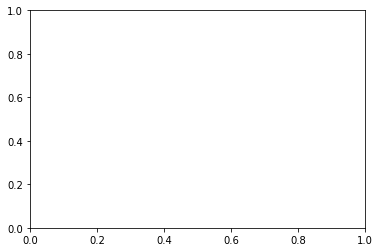

In [8]:
#histogram of driver countries
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(wins_by_constructor['name_constr'])
ax.set_title('''Driver's Home Countries''')
plt.show()